In [1]:
from dataset import sequence
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
class Seq2seqlm:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        rn = np.random.randn
        enc_embed = (rn(V, D) / 100).astype('f')
        enc_lstmWx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        enc_lstmWh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        enc_lstmb = np.zeros(4 * H).astype('f')
        
        dec_embed = (rn(V, D) / 100).astype('f')
        dec_lstmWx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        dec_lstmWh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        dec_lstmb = np.zeros(4 * H).astype('f')
        dec_affineW = (rn(H, V) / np.sqrt(H)).astype('f')
        dec_affineb = np.zeros(V).astype('f')
        
        self.params = [enc_embed, enc_lstmWx, enc_lstmWh, enc_lstmb, \
            dec_embed, dec_lstmWx, dec_lstmWh, dec_lstmb, dec_affineW, dec_affineb]
        
        self.grads = []
        self.enc_lstm = [] 
        self.dec_lstm = []
        
        self.time_idx = 0
        self.vocab_size = vocab_size
        self.wordvec_size = wordvec_size
        self.hidden_size = hidden_size
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.iter = 0
        self.m = None
        self.v = None

        
    def forward(self, enc_xs, ts):
        enc_embed, enc_lstmWx, enc_lstmWh, enc_lstmb, \
            dec_embed, dec_lstmWx, dec_lstmWh, dec_lstmb, dec_affineW, dec_affineb = self.params
        
        self.enc_lstm = []
        self.dec_lstm = []
        
        dec_xs = ts[:, :-1]
        dec_ts = ts[:, 1:]
        
        batch_size, enc_time_size = enc_xs.shape
        dec_time_size = dec_xs.shape[1]
        
        hidden_size = self.hidden_size
               
        ####################### ENCODER #######################
        
        h_prev = np.zeros((batch_size, hidden_size), dtype='f')
        c_prev = np.zeros((batch_size, hidden_size), dtype='f')
        enc_hs = np.zeros((batch_size, enc_time_size, hidden_size), dtype='f')
        for t in range(enc_time_size):
            # embed
            emb_out = enc_embed[enc_xs[:, t]]

            # lstm
            A = np.matmul(emb_out, enc_lstmWx) + np.matmul(h_prev, enc_lstmWh) + enc_lstmb
            f = A[:, :hidden_size]
            g = A[:, hidden_size: 2*hidden_size]
            i = A[:, 2*hidden_size: 3*hidden_size]
            o = A[:, 3*hidden_size:]

            f = self.sigmoid(f)
            g = np.tanh(g)
            i = self.sigmoid(i)
            o = self.sigmoid(o)

            c_next = f * c_prev + g * i
            h_next = o * np.tanh(c_next)
            
            enc_hs[:, t, :] = h_next
            
            self.enc_lstm.append((emb_out, h_prev, c_prev, f, g, i, o, c_next, h_next))
            
            c_prev = c_next
            h_prev = h_next
            
        
        ####################### DECODER #######################
        
        c_prev = np.zeros((batch_size, hidden_size), dtype='f')
        dec_hs = np.zeros((batch_size, dec_time_size, hidden_size), dtype='f')
        for t in range(dec_time_size):
            # embed
            emb_out = dec_embed[dec_xs[:, t]]
            
            # lstm
            A = np.matmul(emb_out, dec_lstmWx) + np.matmul(h_prev, dec_lstmWh) + dec_lstmb
            f = A[:, :hidden_size]
            g = A[:, hidden_size: 2*hidden_size]
            i = A[:, 2*hidden_size: 3*hidden_size]
            o = A[:, 3*hidden_size:]

            f = self.sigmoid(f)
            g = np.tanh(g)
            i = self.sigmoid(i)
            o = self.sigmoid(o)

            c_next = f * c_prev + g * i
            h_next = o * np.tanh(c_next)
            
            dec_hs[:, t, :] = h_next
            
            self.dec_lstm.append((emb_out, h_prev, c_prev, f, g, i, o, c_next, h_next))
            c_prev = c_next
            h_prev = h_next
            
            
        # affine
        dec_hs = dec_hs.reshape(batch_size * dec_time_size, -1)
        dec_affine_out = np.matmul(dec_hs, dec_affineW) + dec_affineb
        
        # softmax
        y = self.softmax(dec_affine_out.reshape(batch_size, dec_time_size, -1))
        loss = self.getLoss(y, dec_ts)
        
        self.xs = enc_xs, enc_hs, dec_xs, dec_hs, dec_affine_out, y
        self.ts = dec_ts
        return loss
        
    def backward(self):
        enc_embed, enc_lstmWx, enc_lstmWh, enc_lstmb, \
            dec_embed, dec_lstmWx, dec_lstmWh, dec_lstmb, dec_affineW, dec_affineb = self.params
        enc_xs, enc_hs, dec_xs, dec_hs, dec_affine_out, y = self.xs
        dec_ts = self.ts
        
        vocab_size = self.vocab_size        
        wordvec_size = self.wordvec_size
        batch_size, enc_time_size = enc_xs.shape
        dec_time_size = dec_xs.shape[1]
        
        ####################### DECODER #######################
        
        # softmax
        y = y.reshape(batch_size * dec_time_size, -1)
        y[np.arange(batch_size * dec_time_size), dec_ts.reshape(batch_size * dec_time_size)] -= 1
        soft_dout = y
        
        # affine
        dec_hs = dec_hs.reshape(batch_size * dec_time_size, -1)
        dec_affine_dout = np.matmul(soft_dout, dec_affineW.T).reshape(batch_size, dec_time_size, -1) 
        dec_affinedW = np.matmul(dec_hs.T, soft_dout) 
        dec_affinedb = np.sum(soft_dout, axis=0)       

        # lstm
        dec_lstmdWx = np.zeros_like(dec_lstmWx)
        dec_lstmdWh = np.zeros_like(dec_lstmWh)
        dec_lstmdb = np.zeros_like(dec_lstmb)
        
        dec_lstm_douts = np.empty((batch_size, dec_time_size, wordvec_size), dtype='f')
        dh, dc = 0, 0
        for t in reversed(range(dec_time_size)):            
            emb_out, h_prev, c_prev, f, g, i, o, c_next, _ = self.dec_lstm[t]
            dh_next = dec_affine_dout[:, t, :] + dh
            dc_next = dc

            tanh_c_next = np.tanh(c_next)
            
            ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
            
            dc_prev = ds * f
            
            di = ds * g
            df = ds * c_prev
            do = dh_next * tanh_c_next
            dg = ds * i
            
            di *= i * (1 - i)
            df *= f * (1 - f)
            do *= o * (1 - o)
            dg *= (1 - g ** 2)
            
            dA = np.hstack((df, dg, di, do))
            
            dWh = np.matmul(h_prev.T, dA)
            dWx = np.matmul(emb_out.T, dA)
            db = np.sum(dA, axis=0)
            
            dec_lstm_douts[:, t, :] = np.matmul(dA, dec_lstmWx.T)
            dh_prev = np.matmul(dA, dec_lstmWh.T)
        
            dec_lstmdWx += dWx
            dec_lstmdWh += dWh
            dec_lstmdb += db
            dh = dh_prev
            dc = dc_prev
            
        # embed
        dec_embed_dout = np.zeros_like(dec_embed)
        for t in range(dec_time_size):
            np.add.at(dec_embed_dout, dec_xs[:, t], dec_lstm_douts[:, t, :])
            
        ####################### ENCODER #######################
        
        # lstm
        enc_lstmdWx = np.zeros_like(enc_lstmWx)
        enc_lstmdWh = np.zeros_like(enc_lstmWh)
        enc_lstmdb = np.zeros_like(enc_lstmb)
        
        enc_lstm_douts = np.empty((batch_size, enc_time_size, wordvec_size), dtype='f')
        dc = 0
        for t in reversed(range(enc_time_size)):            
            emb_out, h_prev, c_prev, f, g, i, o, c_next, _ = self.enc_lstm[t]
            dh_next = dh
            dc_next = dc

            tanh_c_next = np.tanh(c_next)
            
            ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
            
            dc_prev = ds * f
            
            di = ds * g
            df = ds * c_prev
            do = dh_next * tanh_c_next
            dg = ds * i
            
            di *= i * (1 - i)
            df *= f * (1 - f)
            do *= o * (1 - o)
            dg *= (1 - g ** 2)
            
            dA = np.hstack((df, dg, di, do))
            
            dWh = np.matmul(h_prev.T, dA)
            dWx = np.matmul(emb_out.T, dA)
            db = np.sum(dA, axis=0)
            
            enc_lstm_douts[:, t, :] = np.matmul(dA, enc_lstmWx.T)
            dh_prev = np.matmul(dA, enc_lstmWh.T)
        
            enc_lstmdWx += dWx
            enc_lstmdWh += dWh
            enc_lstmdb += db
            dh = dh_prev
            dc = dc_prev        
        
        # embed
        enc_embed_dout = np.zeros_like(enc_embed)
        for t in range(enc_time_size):
            np.add.at(enc_embed_dout, enc_xs[:, t], enc_lstm_douts[:, t, :])
        
        self.grads = enc_embed_dout, enc_lstmdWx, enc_lstmdWh, enc_lstmdb, \
            dec_embed_dout, dec_lstmdWx, dec_lstmdWh, dec_lstmdb, dec_affinedW, dec_affinedb
        
    def softmax(self, y):
        y = y - np.max(y)
        y = np.exp(y)
        y = y / y.sum(axis=-1, keepdims=True)
        return y
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def getLoss(self, y, t):
        N, T, V = y.shape

        y = y.reshape(N * T, V)
        t = t.reshape(N * T)

        ls = np.log(y[np.arange(N * T), t])
        return -np.sum(ls) / (N * T)
                
    def updateAdam(self, lr):
        params = self.params
        grads = self.grads
        
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
                
        self.iter += 1
        lr_t = lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)
        self.params = params
        
    def clip_grads(self, max_norm):
        grads = self.grads
        total_norm = 0
        
        for grad in grads:
            total_norm += np.sum(grad**2)
            
        total_norm = np.sqrt(total_norm)
        
        rate = max_norm / (total_norm + 1e-6)
        
        if rate  < 1:
            for grad in grads:
                grad *= rate
        self.grads = grads
            
    def generate(self, xs, start_id, sample_size):
        enc_embed, enc_lstmWx, enc_lstmWh, enc_lstmb, \
            dec_embed, dec_lstmWx, dec_lstmWh, dec_lstmb, dec_affineW, dec_affineb = self.params
        
        
        enc_time_size = xs.shape[1]
        hidden_size = self.hidden_size
        
        ####################### ENCODER #######################
        
        h_prev = np.zeros((hidden_size), dtype='f')
        c_prev = np.zeros((hidden_size), dtype='f')
        for t in range(enc_time_size):
            # embed
            emb_out = enc_embed[xs[:, t]]

            # lstm
            A = np.matmul(emb_out, enc_lstmWx) + np.matmul(h_prev, enc_lstmWh) + enc_lstmb
            f = A[:, :hidden_size]
            g = A[:, hidden_size: 2*hidden_size]
            i = A[:, 2*hidden_size: 3*hidden_size]
            o = A[:, 3*hidden_size:]

            f = self.sigmoid(f)
            g = np.tanh(g)
            i = self.sigmoid(i)
            o = self.sigmoid(o)

            c_next = f * c_prev + g * i
            h_next = o * np.tanh(c_next)
            
            c_prev = c_next
            h_prev = h_next
                        
        sampled = []
        sample_id = start_id

        ####################### DECODER #######################

        c_prev = np.zeros((hidden_size), dtype='f')
        for _ in range(sample_size):
            
            # embed
            emb_out = dec_embed[sample_id]

            # lstm
            A = np.matmul(emb_out, dec_lstmWx) + np.matmul(h_prev, dec_lstmWh) + dec_lstmb
            f = A[:, :hidden_size]
            g = A[:, hidden_size: 2*hidden_size]
            i = A[:, 2*hidden_size: 3*hidden_size]
            o = A[:, 3*hidden_size:]

            f = self.sigmoid(f)
            g = np.tanh(g)
            i = self.sigmoid(i)
            o = self.sigmoid(o)

            c_next = f * c_prev + g * i
            h_next = o * np.tanh(c_next)

            c_prev = c_next
            h_prev = h_next
            
            # affine
            dec_affine_out = np.matmul(h_next, dec_affineW) + dec_affineb
            
            # softmax
            y = self.softmax(dec_affine_out)
            sample_id = np.argmax(y.flatten())
            sampled.append(int(sample_id))
        
        return sampled
            
    def eval_seq2seq(self, question, correct, id_to_char,
                     verbos=False, is_reverse=False):
        correct = correct.flatten()
        start_id = correct[0]
        correct = correct[1:]
        guess = self.generate(question, start_id, len(correct))

        question = ''.join([id_to_char[int(c)] for c in question.flatten()])
        correct = ''.join([id_to_char[int(c)] for c in correct])
        guess = ''.join([id_to_char[int(c)] for c in guess])

        if verbos:
            if is_reverse:
                question = question[::-1]

            print('Q', question)
            print('T', correct)

            if correct == guess:
                mark = 'O'
                print(mark + ' ' + guess)
            else:
                mark = 'X'
                print(mark + ' ' + guess)
            print('---')

        return 1 if guess == correct else 0

In [3]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [4]:
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0
data_size = len(x_train)
learning_rate = 0.001
data_size = len(x_train)
max_iters = data_size // batch_size

In [5]:
model = Seq2seqlm(vocab_size, wordvec_size, hidden_size) 

In [6]:
acc_list = []
loss_list = []
start_time = time.time()
total_loss, loss_count = 0, 0

for epoch in range(max_epoch):
    idx = np.random.permutation(np.arange(data_size))
    x_train = x_train[idx]
    t_train = t_train[idx]
    
    for iters in range(max_iters):
        batch_x = x_train[(iters * batch_size) : (iters + 1) * batch_size]
        batch_t = t_train[(iters * batch_size) : (iters + 1) * batch_size]
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        model.clip_grads(max_grad)
        model.updateAdam(learning_rate)
        
        total_loss += loss
        loss_count += 1
        
        if iters % 20 == 0:
            avg_loss = total_loss / loss_count
            elapsed_time = time.time() - start_time
            print('| epoch %d |  iters %d / %d | time %d[s] | loss %.2f'
                % (epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0
            
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += model.eval_seq2seq(question, correct, id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('accuracy %.3f%%' % (acc * 100))

| epoch 1 |  iters 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iters 21 / 351 | time 2[s] | loss 2.52
| epoch 1 |  iters 41 / 351 | time 4[s] | loss 2.12
| epoch 1 |  iters 61 / 351 | time 8[s] | loss 1.94
| epoch 1 |  iters 81 / 351 | time 10[s] | loss 1.89
| epoch 1 |  iters 101 / 351 | time 13[s] | loss 1.85
| epoch 1 |  iters 121 / 351 | time 15[s] | loss 1.83
| epoch 1 |  iters 141 / 351 | time 17[s] | loss 1.79
| epoch 1 |  iters 161 / 351 | time 19[s] | loss 1.78
| epoch 1 |  iters 181 / 351 | time 21[s] | loss 1.77
| epoch 1 |  iters 201 / 351 | time 22[s] | loss 1.77
| epoch 1 |  iters 221 / 351 | time 24[s] | loss 1.76
| epoch 1 |  iters 241 / 351 | time 25[s] | loss 1.76
| epoch 1 |  iters 261 / 351 | time 27[s] | loss 1.76
| epoch 1 |  iters 281 / 351 | time 28[s] | loss 1.75
| epoch 1 |  iters 301 / 351 | time 30[s] | loss 1.75
| epoch 1 |  iters 321 / 351 | time 32[s] | loss 1.75
| epoch 1 |  iters 341 / 351 | time 34[s] | loss 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164


| epoch 7 |  iters 221 / 351 | time 266[s] | loss 1.16
| epoch 7 |  iters 241 / 351 | time 268[s] | loss 1.16
| epoch 7 |  iters 261 / 351 | time 269[s] | loss 1.15
| epoch 7 |  iters 281 / 351 | time 271[s] | loss 1.16
| epoch 7 |  iters 301 / 351 | time 272[s] | loss 1.19
| epoch 7 |  iters 321 / 351 | time 274[s] | loss 1.16
| epoch 7 |  iters 341 / 351 | time 276[s] | loss 1.13
Q 77+85  
T 162 
X 168 
---
Q 975+164
T 1139
X 1170
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
X 433 
---
Q 600+257
T 857 
X 809 
---
Q 761+292
T 1053
X 1003
---
Q 830+597
T 1427
X 1493
---
Q 26+838 
T 864 
X 861 
---
Q 143+93 
T 236 
X 209 
---
accuracy 2.580%
| epoch 8 |  iters 1 / 351 | time 290[s] | loss 1.15
| epoch 8 |  iters 21 / 351 | time 291[s] | loss 1.14
| epoch 8 |  iters 41 / 351 | time 293[s] | loss 1.14
| epoch 8 |  iters 61 / 351 | time 295[s] | loss 1.14
| epoch 8 |  iters 81 / 351 | time 296[s] | loss 1.16
| epoch 8 |  iters 101 / 351 | time 298[s] | loss 

accuracy 5.120%
| epoch 14 |  iters 1 / 351 | time 582[s] | loss 0.95
| epoch 14 |  iters 21 / 351 | time 584[s] | loss 0.96
| epoch 14 |  iters 41 / 351 | time 586[s] | loss 0.98
| epoch 14 |  iters 61 / 351 | time 587[s] | loss 0.98
| epoch 14 |  iters 81 / 351 | time 589[s] | loss 0.95
| epoch 14 |  iters 101 / 351 | time 591[s] | loss 0.94
| epoch 14 |  iters 121 / 351 | time 592[s] | loss 0.95
| epoch 14 |  iters 141 / 351 | time 594[s] | loss 0.97
| epoch 14 |  iters 161 / 351 | time 595[s] | loss 0.95
| epoch 14 |  iters 181 / 351 | time 597[s] | loss 0.95
| epoch 14 |  iters 201 / 351 | time 598[s] | loss 0.95
| epoch 14 |  iters 221 / 351 | time 600[s] | loss 0.95
| epoch 14 |  iters 241 / 351 | time 601[s] | loss 0.95
| epoch 14 |  iters 261 / 351 | time 602[s] | loss 0.94
| epoch 14 |  iters 281 / 351 | time 604[s] | loss 0.95
| epoch 14 |  iters 301 / 351 | time 605[s] | loss 0.94
| epoch 14 |  iters 321 / 351 | time 607[s] | loss 0.94
| epoch 14 |  iters 341 / 351 | time 6

| epoch 20 |  iters 161 / 351 | time 818[s] | loss 0.91
| epoch 20 |  iters 181 / 351 | time 820[s] | loss 0.95
| epoch 20 |  iters 201 / 351 | time 821[s] | loss 0.95
| epoch 20 |  iters 221 / 351 | time 822[s] | loss 0.89
| epoch 20 |  iters 241 / 351 | time 824[s] | loss 0.88
| epoch 20 |  iters 261 / 351 | time 826[s] | loss 0.89
| epoch 20 |  iters 281 / 351 | time 828[s] | loss 0.85
| epoch 20 |  iters 301 / 351 | time 831[s] | loss 0.87
| epoch 20 |  iters 321 / 351 | time 833[s] | loss 0.87
| epoch 20 |  iters 341 / 351 | time 835[s] | loss 0.86
Q 77+85  
T 162 
X 160 
---
Q 975+164
T 1139
X 1117
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
X 167 
---
Q 367+55 
T 422 
X 418 
---
Q 600+257
T 857 
X 847 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1425
---
Q 26+838 
T 864 
X 857 
---
Q 143+93 
T 236 
X 239 
---
accuracy 6.660%
| epoch 21 |  iters 1 / 351 | time 850[s] | loss 0.87
| epoch 21 |  iters 21 / 351 | time 852[s] | loss 0.89
| epoch 21 |  iters 41 / 351 | time

In [7]:
x_train = x_train[:, ::-1]
x_test = x_test[:, ::-1]
model = Seq2seqlm(vocab_size, wordvec_size, hidden_size)

In [8]:
reverse_acc_list = []
loss_list = []
start_time = time.time()
total_loss, loss_count = 0, 0

for epoch in range(max_epoch):
    idx = np.random.permutation(np.arange(data_size))
    x_train = x_train[idx]
    t_train = t_train[idx]
    
    for iters in range(max_iters):
        batch_x = x_train[(iters * batch_size) : (iters + 1) * batch_size]
        batch_t = t_train[(iters * batch_size) : (iters + 1) * batch_size]
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        model.clip_grads(max_grad)
        model.updateAdam(learning_rate)
        
        total_loss += loss
        loss_count += 1
        
        if iters % 20 == 0:
            avg_loss = total_loss / loss_count
            elapsed_time = time.time() - start_time
            print('| epoch %d |  iters %d / %d | time %d[s] | loss %.2f'
                % (epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0
            
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += model.eval_seq2seq(question, correct, id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    reverse_acc_list.append(acc)
    print('accuracy %.3f%%' % (acc * 100))

| epoch 1 |  iters 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iters 21 / 351 | time 1[s] | loss 2.52
| epoch 1 |  iters 41 / 351 | time 3[s] | loss 2.15
| epoch 1 |  iters 61 / 351 | time 4[s] | loss 1.95
| epoch 1 |  iters 81 / 351 | time 6[s] | loss 1.90
| epoch 1 |  iters 101 / 351 | time 8[s] | loss 1.85
| epoch 1 |  iters 121 / 351 | time 10[s] | loss 1.82
| epoch 1 |  iters 141 / 351 | time 11[s] | loss 1.79
| epoch 1 |  iters 161 / 351 | time 13[s] | loss 1.78
| epoch 1 |  iters 181 / 351 | time 14[s] | loss 1.78
| epoch 1 |  iters 201 / 351 | time 17[s] | loss 1.77
| epoch 1 |  iters 221 / 351 | time 19[s] | loss 1.77
| epoch 1 |  iters 241 / 351 | time 20[s] | loss 1.76
| epoch 1 |  iters 261 / 351 | time 22[s] | loss 1.75
| epoch 1 |  iters 281 / 351 | time 23[s] | loss 1.74
| epoch 1 |  iters 301 / 351 | time 25[s] | loss 1.74
| epoch 1 |  iters 321 / 351 | time 26[s] | loss 1.75
| epoch 1 |  iters 341 / 351 | time 28[s] | loss 1.74
Q   58+77
T 162 
X 102 
---
Q 461+579
T 

| epoch 7 |  iters 221 / 351 | time 243[s] | loss 1.08
| epoch 7 |  iters 241 / 351 | time 245[s] | loss 1.07
| epoch 7 |  iters 261 / 351 | time 246[s] | loss 1.07
| epoch 7 |  iters 281 / 351 | time 247[s] | loss 1.07
| epoch 7 |  iters 301 / 351 | time 249[s] | loss 1.06
| epoch 7 |  iters 321 / 351 | time 250[s] | loss 1.05
| epoch 7 |  iters 341 / 351 | time 251[s] | loss 1.06
Q   58+77
T 162 
X 170 
---
Q 461+579
T 1139
X 1147
---
Q  48+285
T 666 
X 647 
---
Q   551+8
T 163 
X 175 
---
Q  55+763
T 422 
X 427 
---
Q 752+006
T 857 
X 877 
---
Q 292+167
T 1053
X 1073
---
Q 795+038
T 1427
X 1409
---
Q  838+62
T 864 
X 853 
---
Q  39+341
T 236 
X 227 
---
accuracy 4.820%
| epoch 8 |  iters 1 / 351 | time 262[s] | loss 1.06
| epoch 8 |  iters 21 / 351 | time 263[s] | loss 1.05
| epoch 8 |  iters 41 / 351 | time 264[s] | loss 1.04
| epoch 8 |  iters 61 / 351 | time 265[s] | loss 1.04
| epoch 8 |  iters 81 / 351 | time 267[s] | loss 1.04
| epoch 8 |  iters 101 / 351 | time 268[s] | loss 

accuracy 9.740%
| epoch 14 |  iters 1 / 351 | time 465[s] | loss 0.83
| epoch 14 |  iters 21 / 351 | time 467[s] | loss 0.80
| epoch 14 |  iters 41 / 351 | time 469[s] | loss 0.79
| epoch 14 |  iters 61 / 351 | time 470[s] | loss 0.80
| epoch 14 |  iters 81 / 351 | time 472[s] | loss 0.80
| epoch 14 |  iters 101 / 351 | time 473[s] | loss 0.81
| epoch 14 |  iters 121 / 351 | time 474[s] | loss 0.80
| epoch 14 |  iters 141 / 351 | time 475[s] | loss 0.80
| epoch 14 |  iters 161 / 351 | time 477[s] | loss 0.80
| epoch 14 |  iters 181 / 351 | time 478[s] | loss 0.79
| epoch 14 |  iters 201 / 351 | time 479[s] | loss 0.78
| epoch 14 |  iters 221 / 351 | time 481[s] | loss 0.77
| epoch 14 |  iters 241 / 351 | time 482[s] | loss 0.78
| epoch 14 |  iters 261 / 351 | time 483[s] | loss 0.78
| epoch 14 |  iters 281 / 351 | time 485[s] | loss 0.79
| epoch 14 |  iters 301 / 351 | time 486[s] | loss 0.77
| epoch 14 |  iters 321 / 351 | time 487[s] | loss 0.77
| epoch 14 |  iters 341 / 351 | time 4

| epoch 20 |  iters 141 / 351 | time 677[s] | loss 0.63
| epoch 20 |  iters 161 / 351 | time 678[s] | loss 0.64
| epoch 20 |  iters 181 / 351 | time 680[s] | loss 0.62
| epoch 20 |  iters 201 / 351 | time 681[s] | loss 0.62
| epoch 20 |  iters 221 / 351 | time 682[s] | loss 0.62
| epoch 20 |  iters 241 / 351 | time 684[s] | loss 0.64
| epoch 20 |  iters 261 / 351 | time 685[s] | loss 0.61
| epoch 20 |  iters 281 / 351 | time 686[s] | loss 0.62
| epoch 20 |  iters 301 / 351 | time 688[s] | loss 0.62
| epoch 20 |  iters 321 / 351 | time 689[s] | loss 0.62
| epoch 20 |  iters 341 / 351 | time 690[s] | loss 0.63
Q   58+77
T 162 
X 158 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
X 665 
---
Q   551+8
T 163 
X 160 
---
Q  55+763
T 422 
X 420 
---
Q 752+006
T 857 
X 853 
---
Q 292+167
T 1053
X 1050
---
Q 795+038
T 1427
X 1428
---
Q  838+62
T 864 
X 862 
---
Q  39+341
T 236 
X 235 
---
accuracy 12.080%
| epoch 21 |  iters 1 / 351 | time 700[s] | loss 0.61
| epoch 21 |  iters 21 / 351 | ti

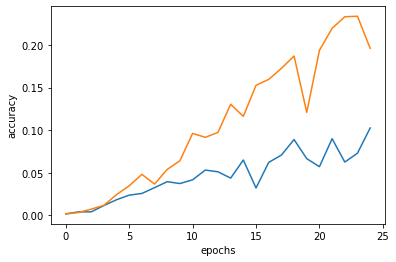

In [9]:
acc = np.arange(len(acc_list))
reverse_acc = np.arange(len(reverse_acc_list))
plt.plot(acc, acc_list, reverse_acc, reverse_acc_list, label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()